In [2]:
import pandas as pd; pd.set_option('display.max_rows', 10)
from pandas.api.types import CategoricalDtype
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import regex
import random
import matplotlib.pyplot as plt
from unicodedata import normalize
from plotnine import *
from typing import List

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text 

from wordcloud import WordCloud, get_single_color_func
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

from pycountry_convert import *


# Explore data

In [3]:
# Import dataset
df = pd.read_csv("un_gen_debates_text.csv")

In [4]:
# Remove the sentence number index
df['text'] = df['text'].replace(r'\d+.','', regex=True)
# Remove tabs
df['text'] = df['text'].replace(r'\t',' ', regex=True)
# Remove line breaks
df['text'] = df['text'].replace(r'\n',' ', regex=True)
# Replace - and _ with whitespace
df['text'] = df['text'].replace('-',' ', regex=False)
df['text'] = df['text'].replace('_',' ', regex=False)


# Word Cloud

In [4]:
# Join all the speeches to make a wordcloud
text = " ".join(speech for speech in df.text)

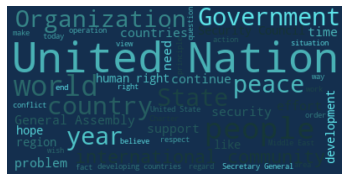

In [5]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color="#142f4e",max_font_size=50, max_words=50).generate(text)

# Display the generated image:

plt.imshow(wordcloud.recolor(color_func=get_single_color_func("#5ce1e6"), random_state=42),
           interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
# Save the image
wordcloud.to_file("./Plots/word_cloud.png")

From the world cloud, we can guess that LDA without further cleanup of the texts won't be any good

# First stab at LDA: No max_df or min_df set

In [7]:
%%time
# 2: create dtm
vec = CountVectorizer(stop_words = 'english',
                      strip_accents = 'unicode',
                      lowercase=True)
X = vec.fit_transform(df["text"])

# 3 create lda
lda = LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=42)
# 4 fit lda
doc_topics = lda.fit_transform(X)

## Get feature names (vocabulary)
voc = np.array(vec.get_feature_names_out())

# Set number of top words you want
n_words=5

# Create lambda function to extract top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

# Use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

# Examine words
words_in_topic


CPU times: user 13 s, sys: 915 ms, total: 13.9 s
Wall time: 31.2 s


[['development', 'nations', 'united', 'international', 'countries'],
 ['nations', 'united', 'international', 'world', 'security'],
 ['united', 'people', 'states', 'countries', 'world'],
 ['united', 'people', 'nations', 'peace', 'world'],
 ['international', 'countries', 'world', 'nations', 'peace']]

Not very helpful!

# Set max_df to 0.5

In [8]:
# 2: create dtm
vec = CountVectorizer(stop_words = 'english',
                      max_df=0.5,
                      strip_accents = 'unicode',
                      lowercase=True)

X = vec.fit_transform(df["text"])


# 3 create lda
lda = LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=42)

# 4 fit lda
doc_topics = lda.fit_transform(X)

## Get feature names (vocabulary)
voc = np.array(vec.get_feature_names_out())

# Set number of top words you want
n_words=5

# Create lambda function to extract top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

# Use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

# Examine words
words_in_topic



[['debt', 'environment', 'democracy', 'continent', 'central'],
 ['america', 'american', 'latin', 'central', 'democracy'],
 ['operation', 'disarmament', 'namibia', 'powers', 'struggle'],
 ['arab', 'israel', 'palestinian', 'iraq', 'israeli'],
 ['sustainable', 'climate', 'reform', 'small', 'terrorism']]

# Create a new word cloud if max_df is set to 0.5

In [9]:
# Count number of times words appear
count = np.asarray(X.sum(axis=0))
count

array([[2, 5, 3, ..., 1, 1, 1]])

In [10]:
count.shape

(1, 51055)

In [11]:
count = count.reshape(count.shape[1])

In [12]:
word = vec.get_feature_names_out()

In [13]:
word.shape

(51055,)

In [14]:
# Create a dictionary of words & their counts
wc = {word: count for word, count in zip(word, count)}

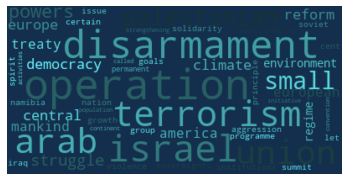

In [15]:
# Generate a word cloud image
wordcloud2 = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color="#142f4e",max_font_size=50, max_words=50).generate_from_frequencies(wc)

# Display the generated image:

plt.imshow(wordcloud2.recolor(color_func=get_single_color_func("#5ce1e6"), random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
# Save the image
wordcloud2.to_file("./Plots/word_cloud2.png")

# 4 topics, max_df = 0.5

In [17]:
# 2: create dtm
vec = CountVectorizer(stop_words = 'english', max_df=0.5,
                      strip_accents = 'unicode',
                      lowercase=True)
X = vec.fit_transform(df["text"])


# 3 create lda
lda = LatentDirichletAllocation(n_components=4, n_jobs=-1, random_state = 42)

# 4 fit lda
doc_topics = lda.fit_transform(X)

## Get feature names (vocabulary)
voc = np.array(vec.get_feature_names_out())

# Set number of top words you want
n_words=5

# Create lambda function to extract top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

# Use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

# Examine words
words_in_topic



[['reform', 'sustainable', 'climate', 'environment', 'goals'],
 ['america', 'american', 'small', 'latin', 'democracy'],
 ['operation', 'disarmament', 'powers', 'struggle', 'namibia'],
 ['arab', 'israel', 'iraq', 'palestinian', 'terrorism']]

# Underneath the hood of max_df

In [18]:
# df = pd.read_csv("un_gen_debates_text.csv")
# df= df[(df.year >= 1980) & (df.year <= 1990)]
# df= df[(df.year >= 1998) & (df.year <= 2000) & (df.country=="USA")]
# df= df[(df.year >= 2001) & (df.country=="SAU")]

In [5]:
# Define function to print out words dropped from using max_df 
def compare_dropped_words(text_column, value1, value2):
    """Get list of words dropped depending on max_df setting for CountVectorizer.

    Keyword arguments:
    text_column -- column with text
    value1 -- first value for max_df; set to 1.0 if don't want to ignore any terms
    value2 -- second value for max_df 
    """
    # Initialize CountVectorizer 
    vect1 = CountVectorizer(stop_words = 'english',strip_accents = 'unicode', lowercase=True,
                            max_df =value1)
    matrix1 = vect1.fit_transform(text_column)
    array1 = vect1.get_feature_names_out()
    
    # Initialize CountVectorizer with max_df
    vect2 = CountVectorizer(stop_words = 'english',strip_accents = 'unicode', lowercase=True,
                            max_df = value2)
    matrix2 = vect2.fit_transform(text_column)
    array2 = vect2.get_feature_names_out()
    
    # Return the difference between 2 lists
    dropped_words = list(set(array1) - set(array2))
    

    if value1 == 1.0:
        print(len(dropped_words), 'words dropped if setting max_df as', value2, 'compared to not setting max_df')
    else:
        print(len(dropped_words), 'words dropped if setting max_df as', value2, 'compared to', value1)       
    
    return dropped_words
    

#### Create different lists of dropped words

In [6]:
dw95 = compare_dropped_words(df['text'],1.0,0.95)

13 words dropped if setting max_df as 0.95 compared to not setting max_df


In [7]:
dw90 = compare_dropped_words(df['text'],0.95,0.90)

8 words dropped if setting max_df as 0.9 compared to 0.95


In [8]:
dw85 = compare_dropped_words(df['text'],0.90,0.85)

10 words dropped if setting max_df as 0.85 compared to 0.9


In [9]:
dw80 = compare_dropped_words(df['text'],0.85,0.80)

12 words dropped if setting max_df as 0.8 compared to 0.85


In [11]:
dw75 = compare_dropped_words(df['text'],0.80,0.75)

16 words dropped if setting max_df as 0.75 compared to 0.8


In [14]:
dw70 = compare_dropped_words(df['text'],0.75,0.70)

15 words dropped if setting max_df as 0.7 compared to 0.75


In [15]:
dw65 = compare_dropped_words(df['text'],0.70,0.65)

27 words dropped if setting max_df as 0.65 compared to 0.7


In [16]:
dw60 = compare_dropped_words(df['text'],0.65,0.60)

35 words dropped if setting max_df as 0.6 compared to 0.65


In [17]:
dw55 = compare_dropped_words(df['text'],0.60,0.55)

31 words dropped if setting max_df as 0.55 compared to 0.6


In [18]:
dw50 = compare_dropped_words(df['text'],0.55,0.50)

47 words dropped if setting max_df as 0.5 compared to 0.55


In [19]:
# Put that into a dictionary
dropped_dict = {"max_df95": dw95, "max_df90": dw90, "max_df85": dw85, "max_df80": dw80, "max_df75":dw75, "max_df70":dw70,"max_df65":dw65,"max_df60":dw60,"max_df55":dw55,"max_df50":dw50}

In [20]:
# Create a pd dataframe from dictonary, use index to allow for varying length
dropped = pd.DataFrame.from_dict(dropped_dict, orient = 'index')

In [21]:
# Create index column
dropped = dropped.reset_index(drop=False)

In [22]:
dropped['value_col'] = range(0, len(dropped))

In [23]:
dropped

,index,0,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,value_col
0,max_df95,states,general,united,development,people,security,new,world,international,...,None,None,None,None,None,None,None,None,None,0
1,max_df90,economic,support,country,efforts,community,political,organization,session,None,...,None,None,None,None,None,None,None,None,None,1
2,max_df85,president,human,time,council,government,years,rights,year,state,...,None,None,None,None,None,None,None,None,None,2
3,max_df80,continue,like,hope,make,today,national,great,mr,important,...,None,None,None,None,None,None,None,None,None,3
4,max_df75,role,way,action,progress,election,end,problems,process,social,...,None,None,None,None,None,None,None,None,None,4
5,max_df70,conflict,place,members,resources,peoples,right,principles,war,just,...,None,None,None,None,None,None,None,None,None,5
6,max_df65,special,africa,recent,measures,based,relations,high,law,middle,...,None,None,None,None,None,None,None,None,None,6
7,max_df60,major,agreement,conflicts,view,concern,democratic,responsibility,parties,particularly,...,None,None,None,None,None,None,None,None,None,7
8,max_df55,given,success,present,needs,adopted,remain,able,meeting,challenges,...,None,None,None,None,None,None,None,None,None,8
9,max_df50,agenda,promote,freedom,effort,concerned,especially,clear,greater,making,...,forces,dialogue,attention,area,lead,comprehensive,help,universal,context,9


In [35]:
# Reshape
dropped1 =pd.melt(dropped, id_vars = ['index','value_col'])

In [36]:
# Drop rows with None strings
dropped1 = dropped1[dropped1["value"].str.contains("None")==False]

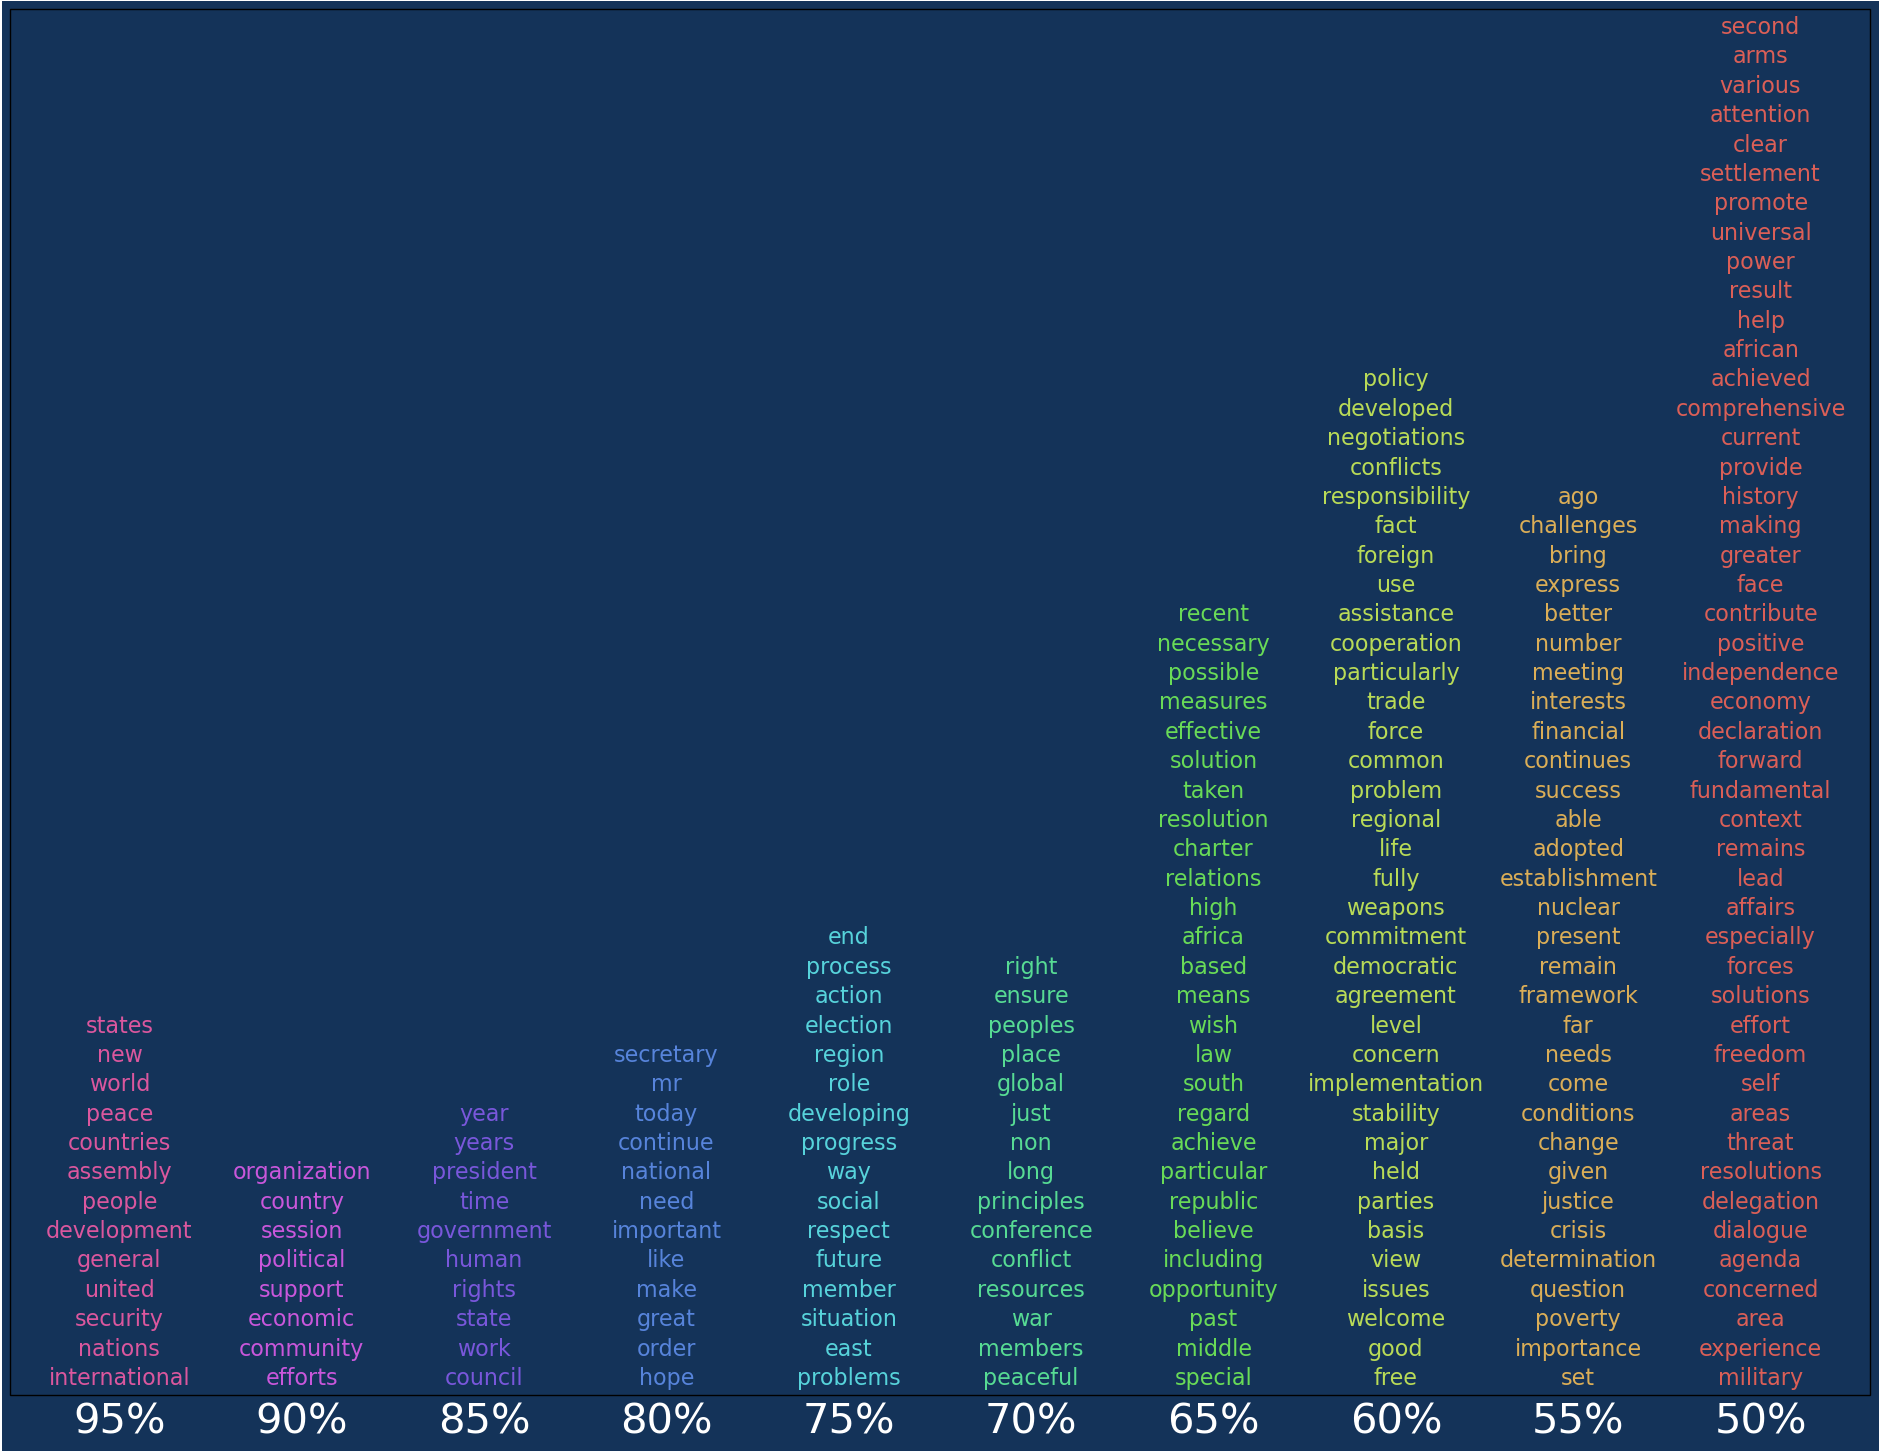

<ggplot: (671266202)>

In [37]:
# Visualize what the dropped words are
dropped_plot = (ggplot(dropped1, aes(x = 'reorder(index, value_col)', y = 'variable')) 
+ geom_point(alpha =0)
+ geom_text(aes(label = 'value',color = 'index'), ha = 'center', size = 16)
+ scale_x_discrete(labels=['95%','90%','85%','80%','75%',
                          '70%','65%','60%','55%','50%'])
+ scale_color_discrete(guide = False)
+ theme_classic()
+ theme(figure_size=(24, 18),
        axis_title_y=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_text_x = element_text(ha='center', size = 30, color ='white'),
        axis_ticks = element_blank(),
        axis_line = element_blank(),
        plot_background=element_rect(fill="#143359"),
        panel_background=element_rect(fill="#143359"),
        panel_border=element_rect(fill="#143359"))
)

dropped_plot

In [38]:
dropped_plot.save('./Plots/dropped_plot.png', dpi = 300)

/Users/chau/miniforge3/envs/ds3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 24 x 18 in image.
/Users/chau/miniforge3/envs/ds3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./Plots/dropped_plot.png


## 0.75 seems like a reasonable cutoff for max_df

In [39]:
# 0.75 cut off
dropped2=dropped[dropped.value_col<=4]
# # Reshape
dropped2 =pd.melt(dropped2, id_vars = ['index','value_col'])
# # Drop rows with None strings:
dropped2 = dropped2[dropped2["value"].str.contains("None")==False]

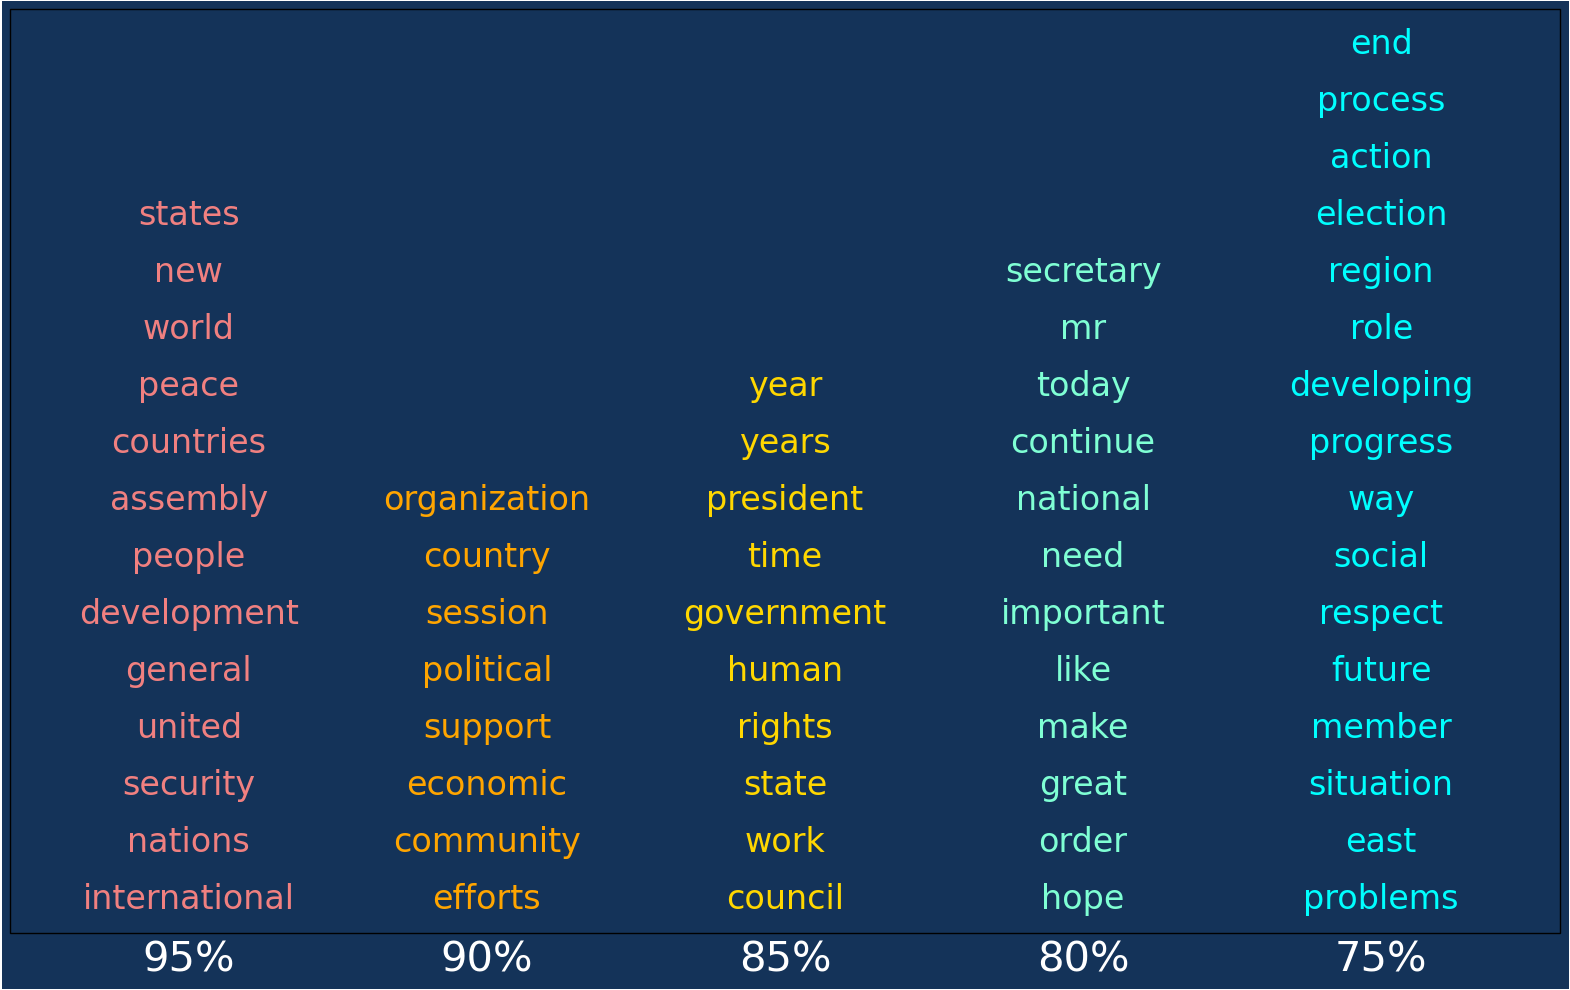

<ggplot: (671122167)>

In [40]:
# Same plot as above but zoom in on 0.75 cutoff values
dropped_plot2 = (ggplot(dropped2, aes(x = 'reorder(index, value_col)', y = 'variable')) 
+ geom_point(alpha =0)
+ geom_text(aes(label = 'value',color = 'index'), ha = 'center', size = 24)
+ scale_x_discrete(labels=['95%','90%','85%','80%','75%'])
+ scale_color_manual(guide = False, values=("cyan","aquamarine","gold","orange","lightcoral"))
+ theme_classic()
+ theme(figure_size=(20, 12),
        axis_title_y=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_text_x = element_text(ha='center', size = 30, color ='white'),
        axis_ticks = element_blank(),
        axis_line = element_blank(),
        plot_background=element_rect(fill="#143359"),
        panel_background=element_rect(fill="#143359"),
        panel_border=element_rect(fill="#143359"))
)
dropped_plot2

In [41]:
dropped_plot2.save('./Plots/dropped_plot2.png', dpi = 300)

/Users/chau/miniforge3/envs/ds3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 20 x 12 in image.
/Users/chau/miniforge3/envs/ds3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./Plots/dropped_plot2.png


In [24]:
# Create list of dropped words
dropped_list = dw95 + dw90 + dw85 + dw80 + dw75
len(dropped_list)

# Add the list of dropped words to sklearn's stop words
modified_stop_words = text.ENGLISH_STOP_WORDS.union(dropped_list)


# Function to subset data & perform LDA

In [25]:
def lda_country(iso3_list: List[str], stop_words = 'english', year_from=1970, year_to=2015, n_components=5, n_words=5,max_df=1.0):
    '''
    Function to get words for topics 
    
    Args:
    iso3_list: [str] - one or multiple countries
    stop_words: 'english' or modified_stop_words
    year_from, year_to - subset the df by years
    n_components - default is 5
    n_words - how many words to print out, default is 5
    max_df - default is 1.0
    
    Returns:
    List of lists of words
    '''
    # subset country
    sub = df[df.country.isin(iso3_list)]
    # subset the year
    sub = sub[(sub.year>= year_from) & (sub.year <= year_to)]

    sub_vec = CountVectorizer(stop_words = stop_words,  max_df=max_df,
                          strip_accents = 'unicode',
                          lowercase=True)
    sub_X = sub_vec.fit_transform(sub["text"])
    sub_lda = LatentDirichletAllocation(n_components=n_components, n_jobs=-1, random_state = 42)
    sub_topics = sub_lda.fit_transform(sub_X)
    sub_voc = np.array(sub_vec.get_feature_names_out())

    sub_imp_words = lambda x: [sub_voc[each] for each in np.argsort(x)[:-n_words-1:-1]]
    sub_words_in_topic = ([sub_imp_words(x) for x in sub_lda.components_])

    return sub_words_in_topic

In [26]:
def lda_all(stop_words = 'english', year_from=1970, year_to=2015, n_components=5, n_words=5,max_df=1.0):
    '''
    Function to get words for topics for all countries
    
    Args:
    stop_words: 'english' or modified_stop_words
    year_from, year_to - subset the df by years
    n_components - default is 5
    n_words - how many words to print out, default is 5
    max_df - default is 1.0
    
    Returns:
    List of lists of words
    '''
    # subset the years
    sub = df[(df.year>= year_from) & (df.year <= year_to)]
    # list of countries in that year
    countries_in_years = list(sub.country.unique())

    sub_vec = CountVectorizer(stop_words = stop_words,  max_df=max_df,
                          strip_accents = 'unicode',
                          lowercase=True)
    sub_X = sub_vec.fit_transform(sub["text"])
    sub_lda = LatentDirichletAllocation(n_components=n_components, n_jobs=-1, random_state = 42)
    sub_topics = sub_lda.fit_transform(sub_X)
    sub_voc = np.array(sub_vec.get_feature_names_out())

    sub_imp_words = lambda x: [sub_voc[each] for each in np.argsort(x)[:-n_words-1:-1]]
    sub_words_in_topic = ([sub_imp_words(x) for x in sub_lda.components_])
    
    sub_cols = ["Topic_" + str(each) for each in range(sub_lda.n_components)]
    sub_docs = ["Document_" + str(each) for each in range(sub_X.shape[0])]
    df_topics = pd.DataFrame(sub_topics,columns=sub_cols,index=sub_docs)
    imp_topic = np.argmax(df_topics.values, axis=1)
    df_topics["top_topic"] = imp_topic
    
    count = np.unique(imp_topic, return_counts= True)  
    doc_count = list(count[1])
    
    return sub_words_in_topic, doc_count

Now that modified_stop_words seems to work pretty well, let's try country subgroups

# All countries, 15 year intervals

In [48]:
%%time
topic_list = []
count_list = []
year_list = []

for i in range(1970,2015,15):
    print("\n Topics in UN speeches between: ", i, " and", i+15)
    topic, count = lda_all(stop_words=modified_stop_words,
                            year_from = i, year_to = i+15, n_components = 5,max_df = 0.75)
    print("\n Topic", topic)
    topic_list.append(topic)
    count_list.append(count)
    year_list.append(i)


 Topics in UN speeches between:  1970  and 1985

 Topic [['israel', 'arab', 'america', 'palestinian', 'american'], ['african', 'certain', 'struggle', 'solidarity', 'justice'], ['struggle', 'nuclear', 'soviet', 'aggression', 'forces'], ['nuclear', 'disarmament', 'global', 'weapons', 'settlement'], ['sea', 'law', 'nuclear', 'disarmament', 'power']]

 Topics in UN speeches between:  1985  and 2000

 Topic [['cooperation', 'nuclear', 'global', 'weapons', 'reform'], ['nuclear', 'republic', 'military', 'afghanistan', 'soviet'], ['africa', 'operation', 'debt', 'problem', 'trade'], ['africa', 'african', 'arab', 'israel', 'palestinian'], ['democracy', 'small', 'century', 'poverty', 'democratic']]

 Topics in UN speeches between:  2000  and 2015

 Topic [['africa', 'african', 'republic', 'conflict', 'poverty'], ['palestinian', 'arab', 'israel', 'iraq', 'terrorism'], ['climate', 'change', 'small', 'sustainable', 'island'], ['poverty', 'peoples', 'cent', 'democracy', 'america'], ['terrorism', 'eu

In [49]:
%%time
# Create dictionary to unpack all the lists
my_dict ={'year':[],'topic_index':[],'top_words':[],'count':[]}
for j in range(len(topic_list)):
    for index, i in enumerate((range(5))):
        t = topic_list[j][i]
        c = count_list[j][i]
        y = year_list[j]
        my_dict['topic_index'].append(index)
        my_dict['top_words'].append(t)
        my_dict['count'].append(c)
        my_dict['year'].append(y)

CPU times: user 14 µs, sys: 1e+03 ns, total: 15 µs
Wall time: 16 µs


In [50]:
world_15year =pd.DataFrame(my_dict).sort_values(by=['year','count'], ascending=True)

In [51]:
world_15year[10:16]

,year,topic_index,top_words,count
13,2000,3,"[poverty, peoples, cent, democracy, america]",353
11,2000,1,"[palestinian, arab, israel, iraq, terrorism]",385
12,2000,2,"[climate, change, small, sustainable, island]",614
14,2000,4,"[terrorism, european, nuclear, law, afghanistan]",798
10,2000,0,"[africa, african, republic, conflict, poverty]",898


# Singapore

In [52]:


for i in range(2000,2015,5):
    print("\n Topics in UN speeches between: ", i, " and", i+5)
    print(lda_country(["SGP"],stop_words=modified_stop_words,
                            year_from = i, year_to = i+5, n_components = 5,max_df = 0.75))


 Topics in UN speeches between:  2000  and 2005
[['september', 'common', 'key', 'attacks', 'consensus'], ['china', 'rules', 'trade', 'chinese', 'taiwan'], ['muslims', 'muslim', 'non', 'islamic', 'religious'], ['iraq', 'interests', 'power', 'members', 'charter'], ['developed', 'peacekeeping', 'millennium', 'trade', 'summit']]

 Topics in UN speeches between:  2005  and 2010
[['regional', 'myanmar', 'asean', 'common', 'powers'], ['asean', 'regional', 'cooperation', 'european', 'organizations'], ['knowledge', 'education', 'urban', 'restructuring', 'cities'], ['economy', 'financial', 'crisis', 'governments', 'meeting'], ['muslims', 'muslim', 'non', 'islamic', 'religious']]

 Topics in UN speeches between:  2010  and 2015
[['urban', 'knowledge', 'education', 'post', 'management'], ['firmly', 'forum', 'effective', 'provide', 'best'], ['firmly', 'forum', 'effective', 'provide', 'best'], ['post', 'isis', 'cooperation', 'conference', 'south'], ['food', 'trade', 'issues', 'groupings', 'multilat

In [27]:


for i in range(2000,2015,5):
    print("\n Topics in UN speeches between: ", i, " and", i+5)
    print(lda_country(["JPN"],stop_words=modified_stop_words,
                            year_from = i, year_to = i+5, n_components = 5,max_df = 0.75))


 Topics in UN speeches between:  2000  and 2005
[['tribute', 'number', 'variety', 'conflicts', 'eradication'], ['issues', 'various', 'arms', 'century', 'prevention'], ['areas', 'iraq', 'destruction', 'consolidation', 'ownership'], ['issues', 'effort', 'regard', 'importance', 'north'], ['eliminate', 'attacks', 'terrorist', 'extend', 'organizations']]

 Topics in UN speeches between:  2005  and 2010
[['challenges', 'bridge', 'climate', 'peacekeeping', 'providing'], ['experiences', 'fight', 'approach', 'decision', 'double'], ['consolidation', 'adoption', 'challenges', 'commission', 'initiative'], ['north', 'ago', 'prosperity', 'july', 'school'], ['billion', 'effort', 'document', 'lead', 'taken']]

 Topics in UN speeches between:  2010  and 2015
[['women', 'police', 'child', 'training', 'personnel'], ['law', 'generations', 'rule', 'wisdom', 'democratic'], ['women', 'energy', 'earthquake', 'economy', 'war'], ['intend', 'climate', 'heartfelt', 'return', 'regarding'], ['women', 'ms', 'childr

In [38]:
skip = 1
for i in range(2000,2015,skip):
    print("\n Topics in UN speeches between: ", i, " and", i+skip)
    print(lda_country(["JPN"],stop_words=modified_stop_words,
                            year_from = i, year_to = i+skip, n_components = 5,max_df = 0.75))


 Topics in UN speeches between:  2000  and 2001
[['issues', 'non', 'proliferation', 'arms', 'reform'], ['afghanistan', 'eliminate', 'attacks', 'terrorist', 'suppression'], ['accede', 'effort', 'spare', 'soon', 'soo'], ['accede', 'effort', 'spare', 'soon', 'soo'], ['accede', 'effort', 'spare', 'soon', 'soo']]

 Topics in UN speeches between:  2001  and 2002
[['hold', 'controlling', 'refugee', 'foreign', 'limited'], ['hold', 'controlling', 'refugee', 'foreign', 'limited'], ['hold', 'controlling', 'refugee', 'foreign', 'limited'], ['eliminate', 'organizations', 'biological', 'activities', 'afghan'], ['building', 'reform', 'areas', 'nation', 'african']]

 Topics in UN speeches between:  2002  and 2003
[['zero', 'determination', 'hard', 'prosperous', 'proposed'], ['zero', 'determination', 'hard', 'prosperous', 'proposed'], ['establishment', 'challenge', 'achieve', 'task', 'peaceful'], ['issues', 'including', 'activities', 'regard', 'north'], ['zero', 'determination', 'hard', 'prosperous', 